In [229]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


# 머신러닝 import 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [195]:
from matplotlib import font_manager, rc
import matplotlib
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family=font_name)


In [196]:
def rmsle(y_true, y_pred, convertExp = True):
    '''
    실제 타깃값과 예측값을 인수로 전달하면 RMSLE 수치를 반환하는 함수
    convertExp : 입력 데이터를 지수변환할지 정하는 파라미터
    타깃값으로 log(count)를 사용한 경우에는 지수변환을 해줘야 함
    '''
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)

    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true + 1))
    log_pred = np.nan_to_num(np.log(y_pred + 1))

    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))

    return output

In [197]:
sample_df = pd.read_csv('./data/bike/sampleSubmission.csv')
sample_df.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [198]:
test_df = pd.read_csv('./data/bike/test.csv')
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [199]:
train_df = pd.read_csv('./data/bike/train.csv')
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [200]:
train_df.shape, test_df.shape

((10886, 12), (6493, 9))

- train 데이터의 컬럼수가 맞지 않으므로 3개 제거

In [201]:
train_nf = train_df.copy()
train_nf

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [202]:
train_nf = train_nf.drop(['casual', 'registered'], axis = 1)

In [203]:
train_nf.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,977.000000


- weather은 사실 1~4 까지 옵션이 4개이므로 컬럼이 4개 추가되는것이 맞는 것 같다.

In [204]:
train_nf[train_nf['weather']== 3].value_counts()

datetime             season  holiday  workingday  weather  temp   atemp   humidity  windspeed  count
2011-01-01 18:00:00  1       0        0           3        17.22  21.210  88        16.9979    35       1
2012-03-02 19:00:00  1       0        1           3        14.76  17.425  87        12.9980    174      1
2012-03-03 00:00:00  1       0        0           3        14.76  18.180  93        6.0032     22       1
2012-03-03 01:00:00  1       0        0           3        14.76  18.940  93        0.0000     44       1
2012-03-03 02:00:00  1       0        0           3        14.76  18.180  93        6.0032     38       1
                                                                                                       ..
2011-09-06 08:00:00  3       0        1           3        22.14  25.760  83        26.0027    364      1
2011-09-06 10:00:00  3       0        1           3        22.14  25.760  83        23.9994    106      1
2011-09-06 11:00:00  3       0        1           3

In [205]:
train_nf[train_nf['weather']== 4]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
5631,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,164


- 폭우와 폭풍번개 치는데 대여한 사람은 이상치로 추정 되므로 드랍 ㄱ ㄱ

In [206]:
train_nf = train_nf[train_nf['weather'] != 4]

In [207]:
train_nf.groupby('weather')

In [208]:
grouped = train_nf.groupby('weather')
result = grouped['weather'].agg(['mean', 'min', 'max', 'count'])
print(result)

         mean  min  max  count
weather                       
1         1.0    1    1   7192
2         2.0    2    2   2834
3         3.0    3    3    859


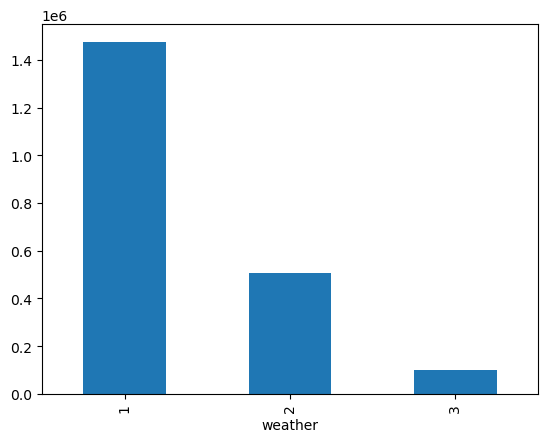

In [27]:
grouped = train_nf.groupby('weather')
result = grouped['count'].sum()
result.plot(kind='bar')
plt.show()

C:\Users\ITSC\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


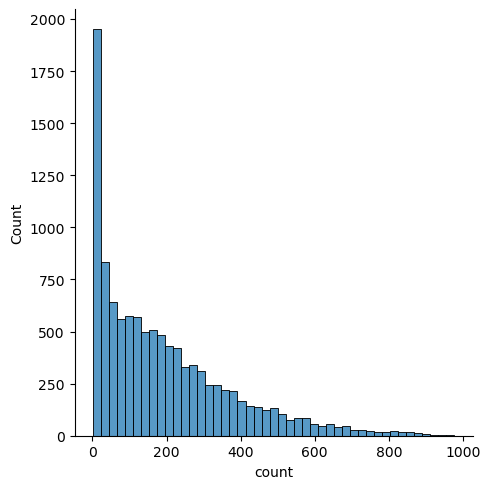

In [28]:
# 분포도 출력 
sns.displot(train_nf['count'])

- 회귀모델이 좋은 성능을 내려면 정규분포를 따라야 하기 때문에 로그변환 ㄱ ㄱ 
- 로그변환은 이와같이 데이터가 왼쪽을 편향되면 씁니당

C:\Users\ITSC\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


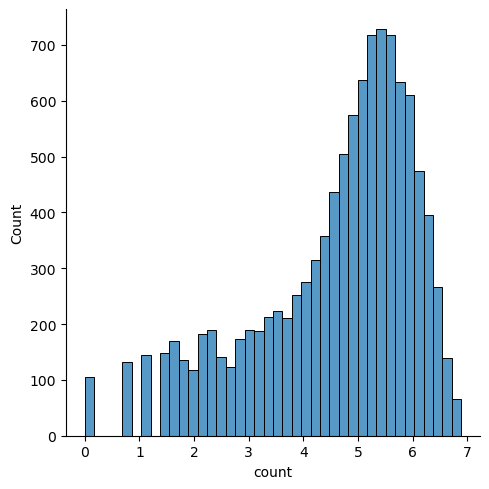

In [29]:
sns.displot(np.log(train_nf['count']))

## 막대 그래프

- 범주형 데이터인 '연도, 년, 월' 등등의 독립변수들을 데이터에 따라 평균 대여수량을 보기위하여 막대그래프를 그릴것임

In [31]:
# 빌린 대여시간을 정확하게 보기 위해서는 시각화가 필요해 보인다 
train_nf['date'] = train_nf['datetime'].apply(lambda x: x.split()[0]) # 날짜 독립변수를 생성

# 연도, 월, 일, 시간 독립변수를 차례로 생성
train_nf['year'] = train_nf['datetime'].apply(lambda x: x.split()[0].split('-')[0]) 
train_nf['month'] = train_nf['datetime'].apply(lambda x: x.split()[0].split('-')[1])
train_nf['day'] = train_nf['datetime'].apply(lambda x: x.split()[0].split('-')[2]) 
train_nf['hour'] = train_nf['datetime'].apply(lambda x: x.split()[1].split(':')[0])

C:\Users\ITSC\AppData\Local\Temp\ipykernel_10896\3481152944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_nf['date'] = train_nf['datetime'].apply(lambda x: x.split()[0]) # 날짜 독립변수를 생성
C:\Users\ITSC\AppData\Local\Temp\ipykernel_10896\3481152944.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_nf['year'] = train_nf['datetime'].apply(lambda x: x.split()[0].split('-')[0])
C:\Users\ITSC\AppData\Local\Temp\ipykernel_10896\3481152944.py:6: SettingWithCopyWarning: 
A value is trying to be set o

In [33]:
train_nf

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,date,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,2011-01-01,2011,01,01,00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,2011-01-01,2011,01,01,01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2011-01-01,2011,01,01,02
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,2011-01-01,2011,01,01,03
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,2011-01-01,2011,01,01,04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,2012-12-19,2012,12,19,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,2012-12-19,2012,12,19,20
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,2012-12-19,2012,12,19,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,129,2012-12-19,2012,12,19,22


In [34]:
train_nf.shape

(10885, 15)

[Text(0.5, 1.0, '시간')]

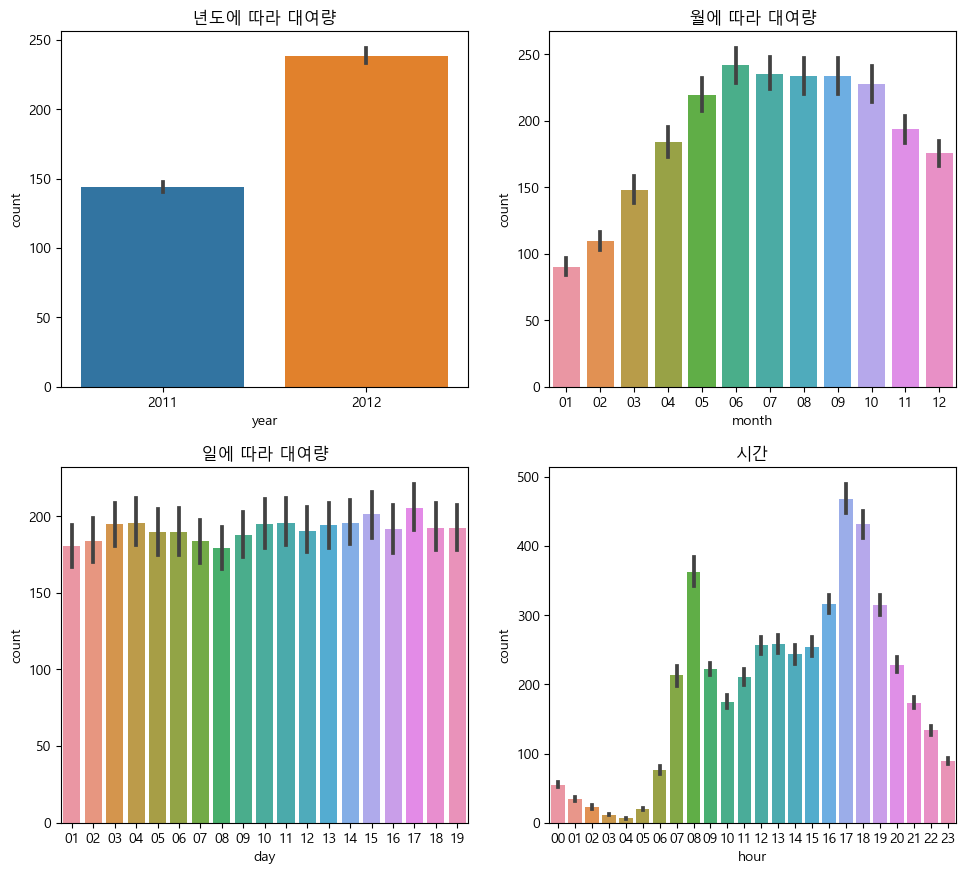

In [47]:
figure, axes = plt.subplots(nrows=2, ncols=2) 
plt.tight_layout()            
figure.set_size_inches(10, 9) 

# 각 축에 연도, 월, 일, 시간평균 대여 수량 막대 그래프 할당
sns.barplot(x='year', y='count', data=train_nf, ax=axes[0, 0])
sns.barplot(x='month', y='count', data=train_nf, ax=axes[0, 1])
sns.barplot(x='day', y='count', data=train_nf, ax=axes[1, 0])
sns.barplot(x='hour', y='count', data=train_nf, ax=axes[1, 1])

axes[0, 0].set(title='년도에 따라 대여량')
axes[0, 1].set(title='월에 따라 대여량')
axes[1, 0].set(title='일에 따라 대여량')
axes[1, 1].set(title='시간')

1. 년도 : 2012년이 현저히 대여량이 많다
2. 월 : 3분기가 제일 대여량이 많다
3. 일 : 일수는 평균적으로 비슷비슷하다. 또한 test 데이터에 20일 부터의 데이터가 있어서 공통된 값이 없으므로 day 독립변수를 지워도 될것같다. 
4. 시간 : 출근시간인 아침 8 시, 오후 5시 6시가 대여량이 높다

In [49]:
train_nf.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'count', 'date', 'year', 'month',
       'day', 'hour'],
      dtype='object')

In [52]:
train_nf['workingday'].value_counts()

workingday
1    7411
0    3474
Name: count, dtype: int64

In [53]:
train_nf['temp'].value_counts()

temp
14.76    467
26.24    453
28.70    427
13.94    413
18.86    406
22.14    403
25.42    403
16.40    400
22.96    395
27.06    394
24.60    390
12.30    385
21.32    362
17.22    356
13.12    356
29.52    353
10.66    332
18.04    328
20.50    327
30.34    299
9.84     294
15.58    255
9.02     248
31.16    242
8.20     228
27.88    224
23.78    203
32.80    202
11.48    181
19.68    170
6.56     146
33.62    130
5.74     107
7.38     106
31.98     98
34.44     80
35.26     76
4.92      60
36.90     46
4.10      44
37.72     34
36.08     23
3.28      11
0.82       7
38.54      7
39.36      6
2.46       5
1.64       2
41.00      1
Name: count, dtype: int64

- 선선한 날씨에 타는 자전거~ 

In [54]:
train_nf['humidity'].value_counts()

humidity
88    368
94    324
83    316
87    289
70    259
     ... 
8       1
10      1
97      1
96      1
91      1
Name: count, Length: 89, dtype: int64

## 포인트 플롯(Point Plot)

 - holiday : 공휴일 여부(0 : 공휴일 아님, 1 : 공휴일)
    - workingday : 근무일 여부(0 : 근무일 아님, 1 : 근무일)
        - 주말과 공휴일이 아니면 근무일이라고 간주 

<Axes: xlabel='hour', ylabel='count'>

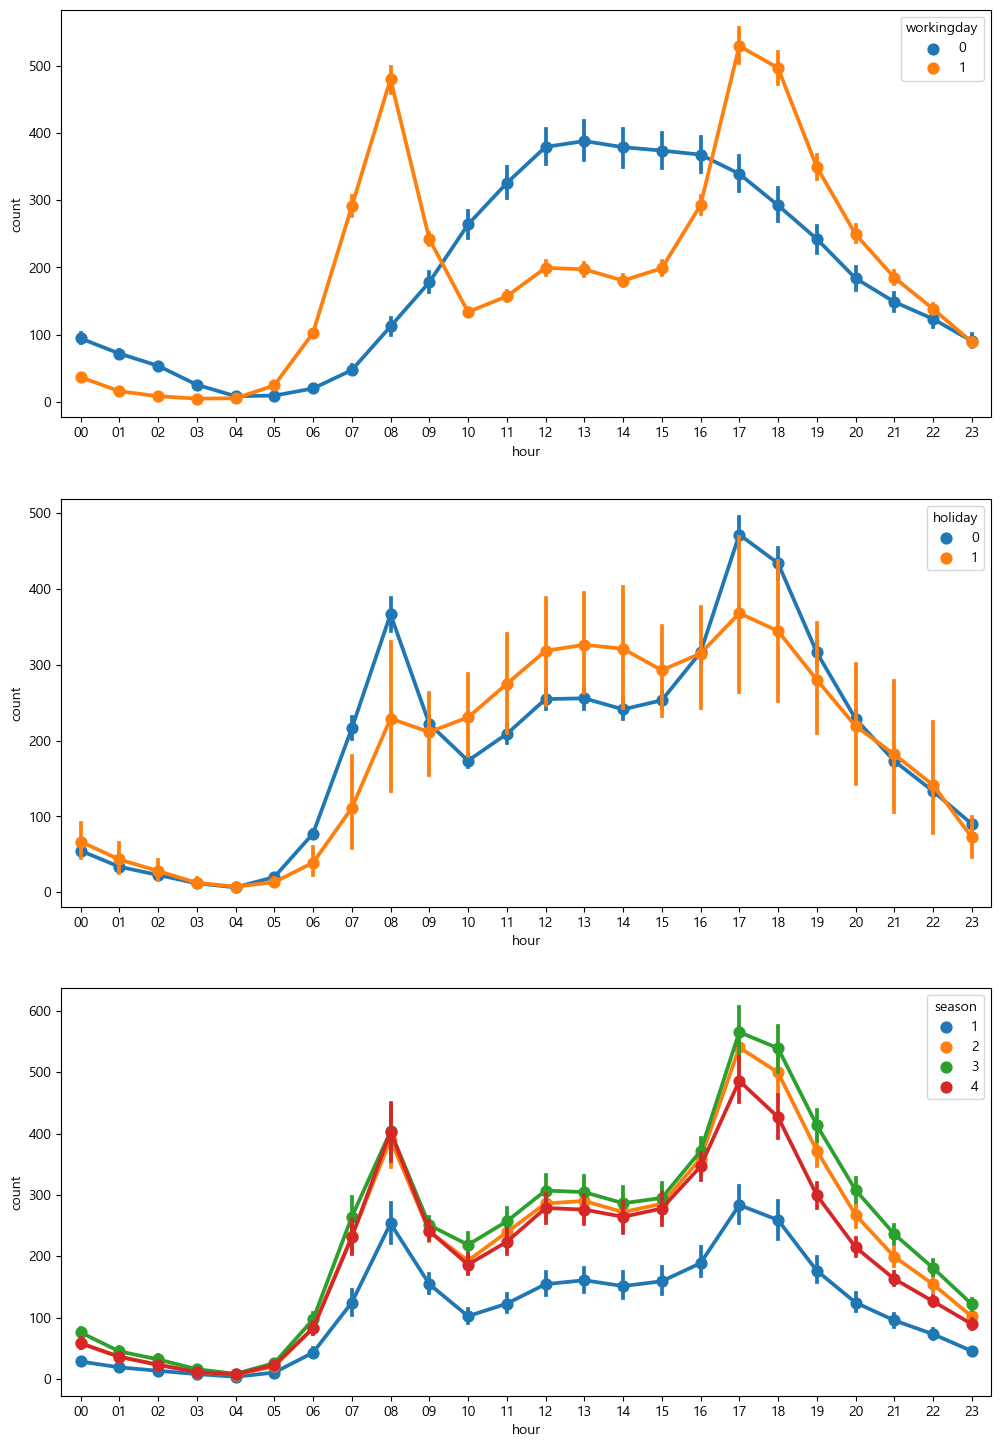

In [64]:
figure, axes = plt.subplots(nrows=3) 
figure.set_size_inches(12, 18)

# 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여 수량 포인트플롯
sns.pointplot(x='hour', y='count', data=train_nf, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='count', data=train_nf, hue='holiday', ax=axes[1])
# sns.pointplot(x='hour', y='count', data=train_nf, hue='weekday', ax=axes[2])
sns.pointplot(x='hour', y='count', data=train_nf, hue='season', ax=axes[2])

- 확실히 working0 과 holiday 의 그래프가 비슷하게 나오며, 예측과 동일하게 겨울에는 자전거 수요가현저히 적음  

## 히트맵으로 상관관계 시각화 하기

In [65]:
train_1 = train_df.drop(['season', 'holiday', 'workingday','casual','registered'], axis =1)
train_1_corr = train_1.corr(numeric_only=True)
train_1_corr

,weather,temp,atemp,humidity,windspeed,count
weather,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655
temp,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000


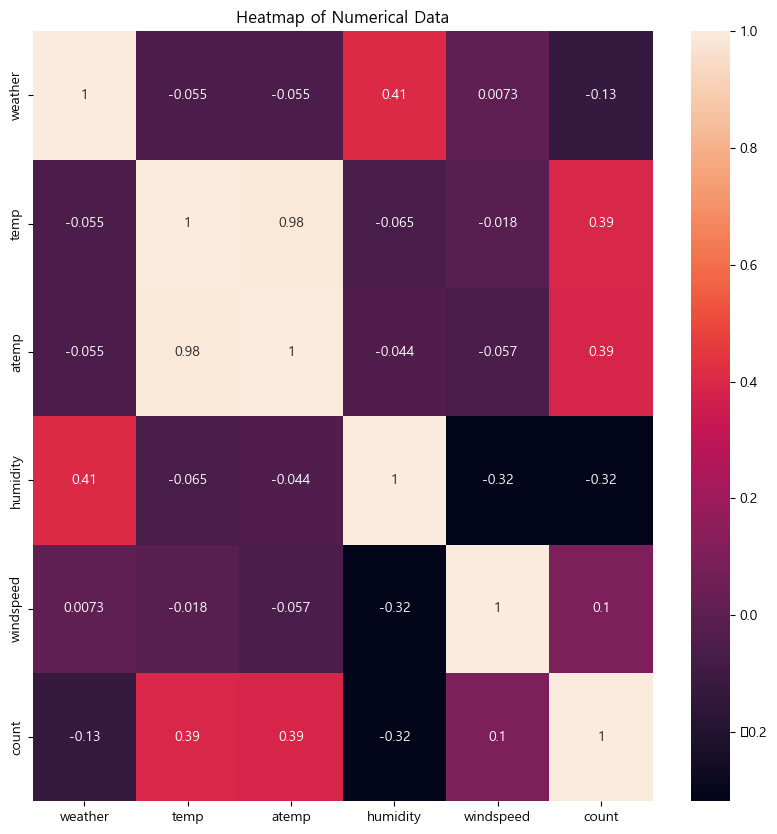

In [66]:
corrMat = train_1_corr
fig, ax= plt.subplots() 
fig.set_size_inches(10, 10)
sns.heatmap(corrMat, annot=True) # 상관관계 히트맵 그리기
ax.set(title='Heatmap of Numerical Data');

- 풍속은 종속변수와 굉장히 상관관계가 낮아서 드랍

In [281]:
ttdata = pd.concat([train_df, test_df], ignore_index=True)
ttdata

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


## 변수들 추가하기 
- 아까 위에서 봤던 것들 처럼, 시간 구체화한 컬럼들 추가 -> - 날짜, 연도, 월, 일, 시간, 요일 독립변수 만들기

In [282]:
from datetime import datetime

# 날짜 피처 생성
ttdata['date'] = ttdata['datetime'].apply(lambda x: x.split()[0])
# 연도 피처 생성
ttdata['year'] = ttdata['datetime'].apply(lambda x: x.split()[0].split('-')[0])
# 월 피처 생성
ttdata['month'] = ttdata['datetime'].apply(lambda x: x.split()[0].split('-')[1])
# 시 피처 생성
ttdata['hour'] = ttdata['datetime'].apply(lambda x: x.split()[1].split(':')[0])
# 요일 피처 생성
ttdata["weekday"] = ttdata['date'].apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())

## 필요없는 독립변수 제거 

In [283]:
drop_features = ['casual', 'registered', 'datetime', 'date', 'month', 'windspeed']
ttdata = ttdata.drop(drop_features, axis=1)

In [284]:
ttdata.head()

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,16.0,2011,00,5
1,1,0,0,1,9.02,13.635,80,40.0,2011,01,5
2,1,0,0,1,9.02,13.635,80,32.0,2011,02,5
3,1,0,0,1,9.84,14.395,75,13.0,2011,03,5
4,1,0,0,1,9.84,14.395,75,1.0,2011,04,5


### 전처리 실수 

In [285]:
ttdata['weather'].value_counts()

weather
1    11413
2     4544
3     1419
4        3
Name: count, dtype: int64

- 이상치 4를 지웠던 데이터프레임을 안 써서  또 4가 나옴. 드랍해주자 

In [286]:
ttdata = ttdata[ttdata['weather'] != 4]

## 데이터 분할

In [287]:
ttdata[pd.isnull(ttdata['count'])]

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,hour,weekday
10886,1,0,1,1,10.66,11.365,56,NaN,2011,00,3
10887,1,0,1,1,10.66,13.635,56,NaN,2011,01,3
10888,1,0,1,1,10.66,13.635,56,NaN,2011,02,3
10889,1,0,1,1,10.66,12.880,56,NaN,2011,03,3
10890,1,0,1,1,10.66,12.880,56,NaN,2011,04,3
...,...,...,...,...,...,...,...,...,...,...,...
17374,1,0,1,2,10.66,12.880,60,NaN,2012,19,0
17375,1,0,1,2,10.66,12.880,60,NaN,2012,20,0
17376,1,0,1,1,10.66,12.880,60,NaN,2012,21,0
17377,1,0,1,1,10.66,13.635,56,NaN,2012,22,0


In [288]:
x_train = ttdata[~pd.isnull(ttdata['count'])] # 전체 데이터에서 count 가 null 이 아닌 값들 
x_test = ttdata[pd.isnull(ttdata['count'])] # count null 값들

In [309]:
x_train.shape

(10885, 10)

In [310]:
x_test.shape

(6491, 10)

In [311]:
pred.shape

(10885,)

In [291]:
x_train = x_train.drop('count', axis = 1)
x_test = x_test.drop('count', axis = 1)
y = train_nf['count']

In [292]:
# x_train, x_test, y_train, y_test = train_test_split(x_train, y, test_size=0.3, random_state=195)

In [293]:
x_test.shape

(6491, 10)

In [294]:
x_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,00,5
1,1,0,0,1,9.02,13.635,80,2011,01,5
2,1,0,0,1,9.02,13.635,80,2011,02,5
3,1,0,0,1,9.84,14.395,75,2011,03,5
4,1,0,0,1,9.84,14.395,75,2011,04,5


In [303]:
linear_reg_model = LinearRegression()

log_y = np.log(y)  # 타깃값 로그변환
linear_reg_model.fit(x_train, log_y) # 모델 훈련


LinearRegression()

In [304]:
preds = linear_reg_model.predict(x_train)

print (f'선형회귀의 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

선형회귀의 RMSLE 값 : 1.0205


In [338]:
sample_df

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
...,...,...
6488,2012-12-31 19:00:00,0
6489,2012-12-31 20:00:00,0
6490,2012-12-31 21:00:00,0
6491,2012-12-31 22:00:00,0


In [307]:
x_train.shape, x_test.shape, y.shape

((10885, 10), (6491, 10), (10885,))

### 교차검증용 평가 함수(RMSLE 점수 계산)

In [298]:
# 교차검증용 평가 함수(RMSLE 점수 계산)
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better= False)

# 모델 생성

rf = RandomForestRegressor()

# 그리드서치 객체 생성

rf_params = {'random_state' : [42] , 'n_estimators' : [100, 120 ,140]} # random_state는 랜덤 시드값 , n_estimators는 랜덤 포레스트를 구성하는 결정 트리 개수

gsrf = GridSearchCV(estimator= rf , param_grid= rf_params ,
                                              scoring = rmsle_scorer , cv=5)

# 그리드서치 수행

log_y = np.log(y)
gsrf.fit(x_train , log_y)

print('최적 하이퍼파라미터 : ' , gsrf.best_params_)

최적 하이퍼파라미터 :  {'n_estimators': 140, 'random_state': 42}


In [270]:
pred = gsrf.best_estimator_.predict(x_train)

# 평가
print(f'랜덤 포레스트 회귀 RMSLE 값 : {rmsle(log_y , pred , True) : .4f}' )


랜덤 포레스트 회귀 RMSLE 값 :  0.1127


Text(0.5, 1.0, '예측 테스트 데이터 분포도')

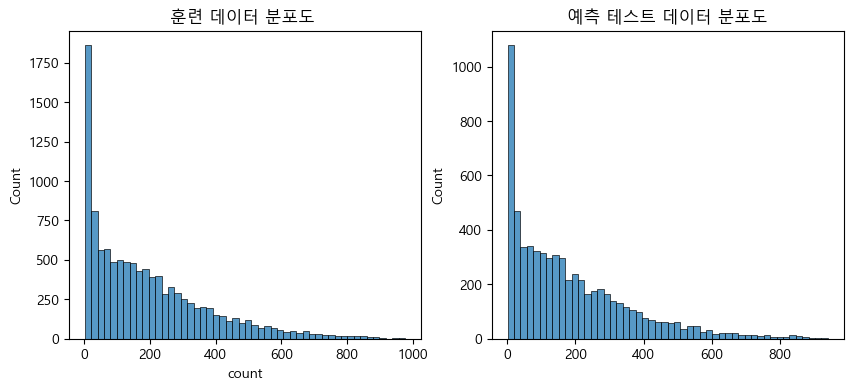

In [271]:
rf_pred = gsrf.best_estimator_.predict(x_test)

fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(10,4)

sns.histplot(y, bins = 50 , ax = ax[0])
ax[0].set_title('훈련 데이터 분포도 ')
sns.histplot(np.exp(rf_pred) , bins = 50 , ax = ax[1])
ax[1].set_title('예측 테스트 데이터 분포도')

In [272]:
test_df_datetime = test_df['datetime']
test_df_datetime

0       2011-01-20 00:00:00
1       2011-01-20 01:00:00
2       2011-01-20 02:00:00
3       2011-01-20 03:00:00
4       2011-01-20 04:00:00
               ...         
6488    2012-12-31 19:00:00
6489    2012-12-31 20:00:00
6490    2012-12-31 21:00:00
6491    2012-12-31 22:00:00
6492    2012-12-31 23:00:00
Name: datetime, Length: 6493, dtype: object

In [273]:
sample_df.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [277]:
pred.shape

(10885,)

<Axes: >

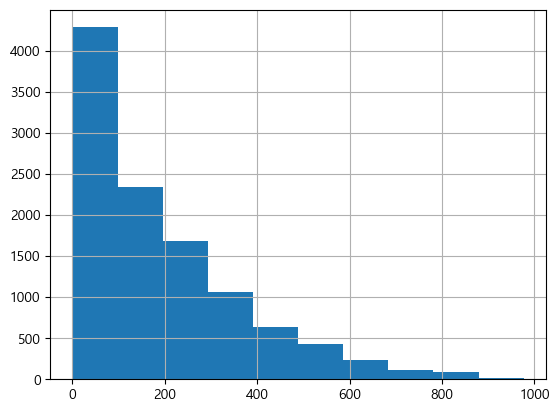

In [280]:
y.hist()

In [345]:
submission = pd.DataFrame()
submission['datatime'] = test_df_datetime
submission['count_log'] = pred(x_test)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
sample_df = pd.read_csv('./data/bike/sampleSubmission.csv')
sample_df.head()

In [348]:
submission = pd.DataFrame()
submission['datatime'] = test_df_datetime

In [354]:
test_df.shape

(6493, 9)

In [355]:
submission.shape

(6493, 1)

In [360]:
submission.shape

(6493, 1)

In [356]:
rf_pred.shape

(6491,)

In [349]:
submission['count'] = np.exp(rf_pred) # 지수변환
submission.to_csv('./submission.csv', index=False)

ValueError: Length of values (6491) does not match length of index (6493)